In [38]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [39]:
env = gym.make('CartPole-v0')
path_to_recording = './tmp/CartPole-v0-gradient'

[2016-12-30 22:49:53,406] Making new env: CartPole-v0


In [71]:
def policy_gradient():
    
    """
    updates the policy gradient based on receiveing a state tensor and an action tensor 
    """
    state = tf.placeholder(dtype = tf.float32, shape = (None, 4))
    actions = tf.placeholder(dtype = tf.float32, shape  = (None, 2))
    advantage = tf.placeholder(dtype = tf.float32, shape  = (None, 1))
    
    linear_weights = tf.Variable(tf.zeros((4, 2)))
    linear = tf.matmul(state, linear_weights)
    est_probs = tf.nn.softmax(linear)
    
    acc = tf.reduce_sum(tf.mul(est_probs, actions), reduction_indices = [1])
    log_probs = tf.log(acc)
    loss = -tf.reduce_sum(log_probs * advantage)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    
    return optimizer, state, actions, advantage, est_probs, loss, linear_weights


def value_gradient():
    """
    a 2 layer Feed Forward Net to estimate the value as a function of the state vector
    """
    state = tf.placeholder(dtype=tf.float32, shape = (None, 4))
    val = tf.placeholder(dtype=tf.float32, shape = (None, 1))
    
    w1 = tf.Variable(tf.random_normal([4, 10]))
    b1 = tf.Variable(tf.zeros([10]))
    h1 = tf.nn.relu(tf.matmul(state, w1) + b1)
    
    w2 = tf.Variable(tf.random_normal([10, 1]))
    b2 = tf.Variable(tf.zeros([1]))
    val_est = tf.matmul(h1, w2) + b2
    
    loss = tf.nn.l2_loss(val_est - val)
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
    return optimizer, state, val, val_est, loss
    

In [83]:
policy_opt, policy_state_var, policy_action_var, policy_advantages_var,  policy_action_est, policy_loss, wts = policy_gradient()
value_opt, value_state_var, value_val_var, value_val_est, value_loss = value_gradient()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [84]:

gamma = 0.97

pol_loss_hist = []
val_loss_hist = []
reward_hist = []
 
for epoch in xrange(1000):
    obs = env.reset()
    states = []
    actions = []
    transitions = []
    total_reward = 0.0
    eps = 1.0/(epoch + 4.0)
    
    while True:
        probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})
        #if np.random.rand() > probs.max():
        #    action = env.action_space.sample()
        #else:
        #    action = 0 if (probs[0][0] > 0.5) else 1
        #print probs
        #THIS EXPLORATION FUNCTION IS THE MOST CRITICAL TO THE SUCCESS
        action = 0 if np.random.rand() < probs[0][0] else 1 #intresting approach.. as you get more confident in your answers the model will start to scale down
        #print obs
        #print action, probs
        
        action_arr = np.zeros(2)
        action_arr[action] = 1.0

        next_obs, reward, done, _ = env.step(action)

        states.append(obs)
        actions.append(action_arr)
        transitions.append((next_obs, reward, done))

        total_reward += reward

        obs = next_obs
        if done or total_reward > 500:
            break
    
    
    future_rewards = []
    for idx, trans in enumerate(transitions):
        obs, rew, done = trans
        cum_reward = 0.0
        for idx2, future_trans in enumerate(transitions[idx:]):
            _, future_reward, _ = future_trans
            #print (gamma**idx2) * future_reward
            cum_reward += (gamma**idx2) * future_reward
        
        future_rewards.append([cum_reward])
    

    #calculate the difference between the true reward and the estimated value
    #if the policy suggests an action, but the true future reward is worse than the predicted result, then it will increase
    #the loss score, which will pull the policy in the other direction
    
    obs_ = [obs for obs, _, _ in  transitions]
    estimated_val = sess.run(value_val_est, feed_dict = {value_state_var : obs_})    
    advantage = np.array(future_rewards) - estimated_val 

    pol_opt, pol_loss = sess.run([policy_opt, policy_loss], feed_dict = {policy_state_var: states, 
                                                                         policy_action_var: actions,
                                                                         policy_advantages_var: advantage
                                                                        })
    
    val_opt, val_loss = sess.run([value_opt, value_loss], feed_dict = {value_state_var: states, value_val_var: future_rewards})
    
    pol_loss_hist.append(pol_loss)
    val_loss_hist.append(val_loss)
    reward_hist.append(total_reward)
    if epoch % 1 == 0:
        print 'episode', epoch, 'total_reward', total_reward, pol_loss, val_loss
    
    

episode 0 total_reward 29.0 7850.97 2856.29
episode 1 total_reward 41.0 18279.9 5651.38
episode 2 total_reward 15.0 1173.43 499.687
episode 3 total_reward 10.0 373.177 169.926
episode 4 total_reward 26.0 5194.64 1931.96
episode 5 total_reward 15.0 1151.03 472.613
episode 6 total_reward 20.0 2801.72 1085.0
episode 7 total_reward 16.0 1314.03 536.549
episode 8 total_reward 25.0 4477.54 1648.77
episode 9 total_reward 41.0 16933.8 5259.39
episode 10 total_reward 14.0 1089.11 463.572
episode 11 total_reward 20.0 2397.1 927.223
episode 12 total_reward 24.0 3789.68 1392.45
episode 13 total_reward 32.0 8884.56 3118.34
episode 14 total_reward 18.0 1704.47 652.58
episode 15 total_reward 11.0 603.492 267.664
episode 16 total_reward 13.0 891.421 359.121
episode 17 total_reward 20.0 2490.5 975.55
episode 18 total_reward 12.0 670.652 301.534
episode 19 total_reward 20.0 2156.34 819.049
episode 20 total_reward 16.0 1405.79 552.816
episode 21 total_reward 19.0 1824.84 698.108
episode 22 total_reward 2

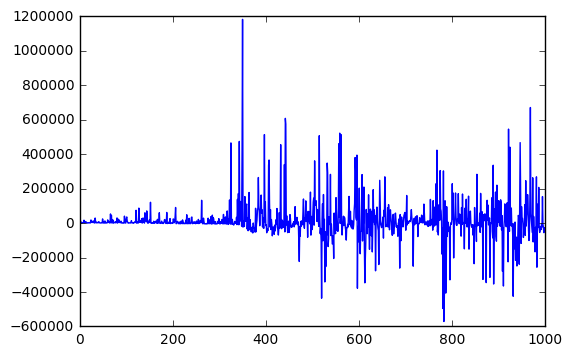

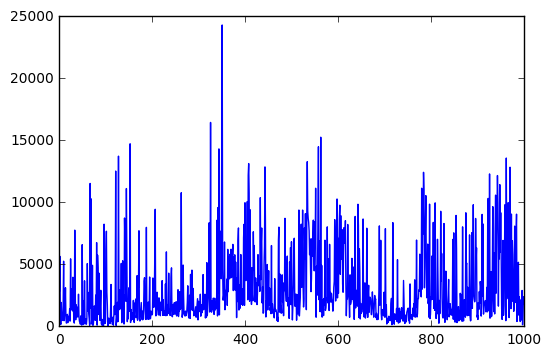

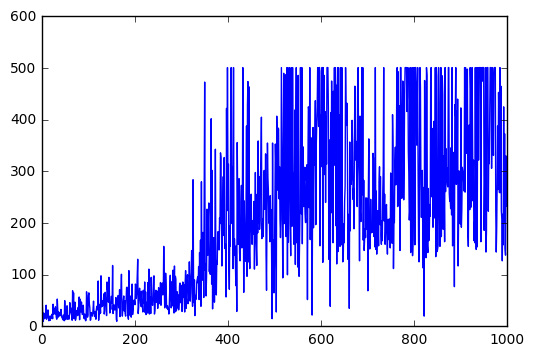

In [85]:
plt.plot(pol_loss_hist)
plt.show()

plt.plot(val_loss_hist)
plt.show()

plt.plot(reward_hist)
plt.show()

In [57]:
sess.run(wts)

array([[-0.1266091 ,  0.12660913],
       [-0.14869115,  0.14869116],
       [-2.462008  ,  2.46200824],
       [-1.69236076,  1.69236112]], dtype=float32)

In [86]:
probs = sess.run(policy_action_est, feed_dict={policy_state_var : obs.reshape((1, obs.shape[0]))})

In [87]:
probs

array([[ 0.79395467,  0.20604533]], dtype=float32)

In [88]:
probs.max()

0.79395467

In [89]:
env.action_space.sample()

1